# SkullGAN: Synthetic Skull CT Generation with Generative Adversarial Networks

Access to a standardized, large enough database of human skull CTs for the purpose of training a neural network architecture on them is nearly impossible. As a result, simulation software written for transcranial ultrasound simulation generally verify their performance via one of the following:
1. Where multiplicity of data is necessary, they simulate toy models of the skull that are simple, homogeneous smooth manifolds. 
2. Where a single simulation is deemed sufficient in verifying their proposed simulation paradigm they use one or two  real human skull CT. 

For our purposes, we are building a neural network that estimates the transcranial pressure field simulated by k-wave (a MATLAB physics-based simulation software) at very high resolutions but at least 1000 times faster. Such a model needs hundreds of thousands of realistic human skulls for accurate verification. Therefore, instead of resorting to toy smooth manifolds as proxies for human skull, we are going to learn the underlying data generating distribution for real human skull CTs using SkullGAN, then sample from them as many realistic but synthetic human skulls as we need.

Paper: [KBP Lab](https://kbplab.stanford.edu/SkullGAN) <br>
Code: [GitHub](https://github.com/kbp-lab/SkullGAN)

## Step 1: Setup

We start by importing all of the necessary packages from PyTorch, NumPy, and other libraries. We also define the training hyperparameters, as well as where to save any produced figures. Lastly, we create some useful functions for data normalization, and managing data transfer between our CPU and GPUs.

In [2]:
## -------------------------------- ##
## IMPORT NECESSARY PACKAGES
## -------------------------------- ##

## ----- SYSTEM ----- ##
import os
import random

## ----- STATS ----- ##
import numpy as np

## ----- TORCH ----- ##
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

## ----- DISPLAY ----- ##
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt
from torchview import draw_graph
%config InlineBackend.figure_format = 'retina'

## ----- MISC ----- ##
from datetime import datetime

## ----- REPRODUCIBILITY ----- ##
seed = 111
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)
torch.backends.cudnn.deterministic = True

/opt/homebrew/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: <3F789787-FE38-3CE7-8599-064BDD0416EE> /opt/homebrew/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <3F9923D2-81A5-3EC8-9739-EC0C1C816132> /opt/homebrew/lib/python3.9/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")


In [3]:
## -------------------------------- ##
## HYPERPARAMETERS
## -------------------------------- ##

# Figure path
fig_path = "figures/"
if not os.path.exists(fig_path): print("Figure Path Does Not Exist!")

# Batch size
batch_size = 16 #64 

# Number of channels (grayscale)
nc = 1

# Size of generator input latent vector
nz = 200

# Size of feature maps in generator
ngf = 256

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 1000

# Learning rate for optimizers
lrD = 3e-4
lrG = 3e-4

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available
ngpu = torch.cuda.device_count()

# Decide which device we want to run on
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if  torch.backends.mps.is_available() else "cpu")

In [4]:
## -------------------------------- ##
## USEFUL FUNCTIONS
## -------------------------------- ##

## ----- WEIGHT INITIALIZATION ----- ##
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.01)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.01)
        nn.init.constant_(m.bias.data, 0)
        
## ----- LATENT VECTOR GENERATOR ----- ##
latent_vec_gen = 'uniform'
def latent_vec(device, size, gen = latent_vec_gen):
    if gen == "normal":
        return torch.randn(size, nz, 1, 1, device=0)
    elif gen == "uniform":
        return torch.distributions.Uniform(-1.0, 1.0).\
               sample(sample_shape=torch.Size([size, nz, 1, 1])).to(device)

## ----- COUNT MODEL PARAMETERS ----- ##        
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## ----- HU STANDARDIZING FUNCTION ----- ##
def standardize(slices, scalings, direction = 1):
    if direction == 0: # FORWARDS
        scalings.append(np.min(slices_org))
        slices = slices_org - np.min(slices_org)     # 0 - 2500

        scalings.append(np.max(slices))
        slices = slices / np.max(slices)             # 0 - 1

        scalings.extend([0.5, 0.5])
        slices = (slices - 0.5) / 0.5                # µ = 0.5, σ = 0.5
        return slices, scalings

    elif direction == 1: # BACKWARDS
        slices = ((slices.squeeze() * 0.5) + 0.5) * scalings[1] + scalings[0]
        return slices
        
## ----- NUMPY -> TENSOR HELPERS ----- ##    
to_t = lambda array: torch.tensor(array, device=device, dtype=torch.float32)
from_t = lambda tensor: tensor.to('cpu').detach().numpy()

## Step 2: Import Training Data

We'll have to figure out what we want to do here. Maybe a dummy dataset of our toy skulls? And maybe we can include a link to the Celeb-A dataset.

In [6]:
## ----- LOAD SAMPLES ----- ##
slices_org = np.load("data/reals/slices_2k.npy")[0:200]

## ----- STANDARDIZE DATA ----- ##
slices, scalings = standardize(slices_org, [], 0)

print("Original Range:", round(np.min(slices_org), 3), "-", round(np.max(slices_org), 3))
print("Standardized Range:", round(np.min(slices), 3), "-", round(np.max(slices), 3))

Original Range: 0.0 - 2264.084
Standardized Range: -1.0 - 1.0


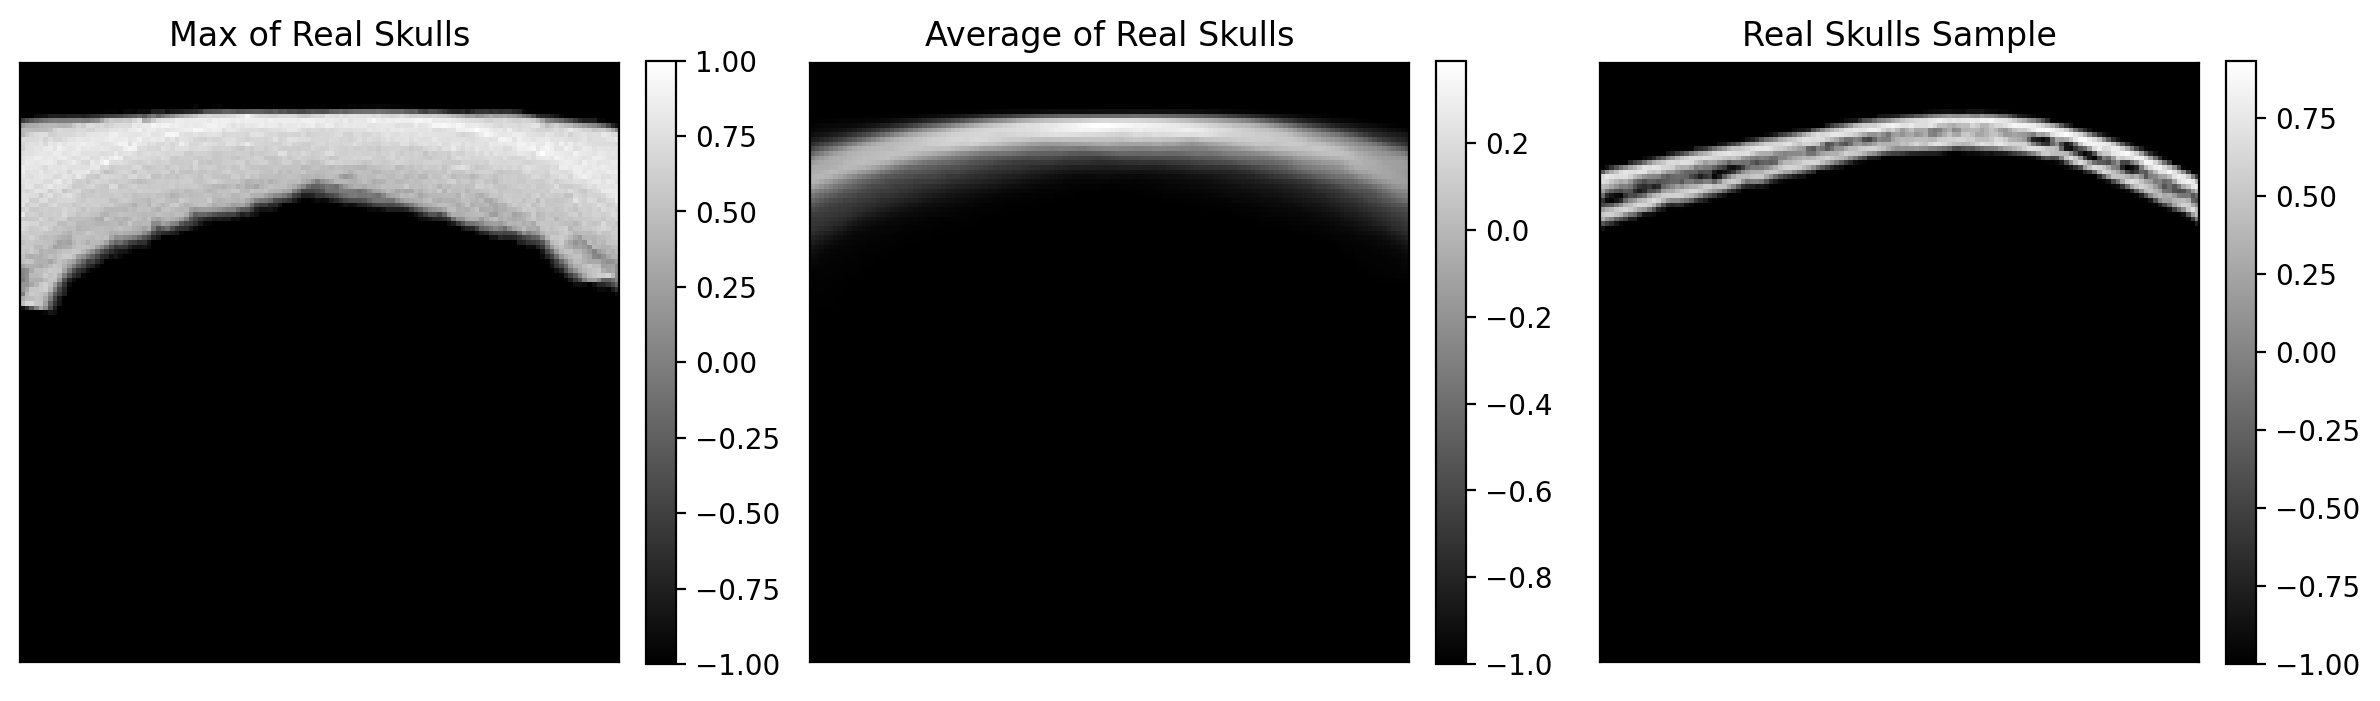

In [7]:
## ----- DISPLAY SKULLS ----- ##
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('Max of Real Skulls')
plt.imshow(np.max(slices.squeeze(), axis=0), cmap='gray')
plt.colorbar(fraction=0.046, pad=0.04)
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 2)
plt.title('Average of Real Skulls')
plt.imshow(np.mean(slices.squeeze(), axis=0), cmap='gray')
plt.colorbar(fraction=0.046, pad=0.04)
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 3)
plt.title('Real Skulls Sample')
plt.imshow(slices[151].squeeze(), cmap='gray')
plt.colorbar(fraction=0.046, pad=0.04)
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

## Step 3: Define Model

In [8]:
## ----------- DATASET ----------- ##
class CustomDataset(Dataset):
    def __init__(self, image, transform=None):
        self.image = image
        self.transform = transform

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        image = self.image[idx]
        if self.transform:
            image = self.transform(image)
        return image.float()

In [9]:
## ----------- DATALOADER ----------- ##
dataset = CustomDataset(to_t(slices))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, 
                        worker_init_fn=np.random.seed(seed))

### Generator

In [10]:
class GeneratorNoise(nn.Module):
    def __init__(self, ngpu, upper_bound, lower_bound, std):
        super(GeneratorNoise, self).__init__()
        self.ngpu = ngpu
        self.upper_bound = upper_bound
        self.lower_bound = lower_bound
        self.std = std
    
    def forward(self, x):
        clone = torch.clone(x)
        pixel_max = torch.amax(clone, (0, 1), True)
        channel_max = torch.amax(clone, (2, 3), True)
        channel_min = torch.amin(clone, (2, 3), True)        
        channel_std = torch.std(x, dim=(2, 3), keepdims=True)
        pixel_std = torch.std(x, dim=(0, 1), keepdims=True)        
        channel_mean = torch.mean(x, dim=(2, 3), keepdims=True)
        pixel_mean = torch.mean(x, dim=(2, 3), keepdims=True)  
        noise = torch.empty_like(x).normal_(mean=0.0, std=1.0).to(device)

        if self.std == 'fixed':
            channel_noise = noise
        elif self.std == 'dynamic':
            channel_noise = noise * channel_std

        clone[clone < - channel_max / self.lower_bound] = 0        
        clone[clone > channel_max / self.upper_bound] = 0        
        return x + clone * channel_noise           

In [11]:
## ----------- GENERATOR ----------- ##
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main1 = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True))
            
            # state size. 4096 x 4 x 4
        self.main2 = nn.Sequential(            
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),            
            nn.ReLU(True))

            # state size. 2048 x 8 x 8
        self.main3 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True))
            
            # state size. 1024 x 16 x 16 
        self.main4 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),            
            nn.ReLU(True))
            
            # state size. 512 x 32 x 32
        self.main5 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True))

            # state size. 256 x 64 x 64        
        self.main6 = nn.Sequential(
            nn.ConvTranspose2d(ngf, round(ngf / 2), 4, 2, 1, bias=False))
            
            # state size. 1 x 128 x 128
        self.conv1 = nn.Conv2d(round(ngf / 2), round(ngf / 4), 3, 1, 1, bias=True)
        self.conv2 = nn.Conv2d(round(ngf / 4), round(ngf / 8), 3, 1, 1, bias=True)
        self.conv3 = nn.Conv2d(round(ngf / 8), round(ngf / 16), 3, 1, 1, bias=True)
        self.conv4 = nn.Conv2d(round(ngf / 16), nc, 3, 1, 1, bias=False)
        self.tanh = nn.Tanh()
 
    def forward(self, input):
        channel_noise_1 = GeneratorNoise(ngpu, upper_bound=4.0, lower_bound=2.0, std='dynamic')                  
        
        x = self.main1(input)
        x = self.main2(x)
        x = self.main3(x)
        x = self.main4(x)
        x = self.main5(x)
        x = self.main6(x)
        x = channel_noise_1(x)
        x = self.conv1(x)                                    
        x = self.conv2(x)  
        x = channel_noise_1(x)             
        x = self.conv3(x)      
        x = self.conv4(x)      
        x = self.tanh(x)
        return x

In [12]:
## ----- INIT GENERATOR ----- ##
netG = Generator(ngpu).to(device)

if torch.cuda.is_available() and ngpu > 1:
    netG = nn.DataParallel(netG, list(range(ngpu)))

## ----- INIT WEIGHTS ----- ##
netG.apply(weights_init)
netG = netG.float()

### Discriminator

In [13]:
## ----------- DISCRIMINATOR ----------- ##
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is 1 x 128 x 128
            nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=True), 
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. 32 x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. 64 x 32 x 32     
            nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. 128 x 16 x 16      
            nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. 256 x 8 x 8    
            nn.Conv2d(ndf * 8, ndf * 16, 4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. 512 x 4 x 4     
            nn.Conv2d(ndf * 16, 1, 4, stride=1, padding=0, bias=True),
            nn.Sigmoid()
            # state size. 1
        )

    def forward(self, input):
        return self.main(input)

In [14]:
## ----- INIT DISCRIMINATOR ----- ##
netD = Discriminator(ngpu).to(device)

if torch.cuda.is_available() and ngpu > 1:
    netD = nn.DataParallel(netD, list(range(ngpu)))

## ----- INIT WEIGHTS ----- ##
netD.apply(weights_init)
netD = netD.float()

## Step 4: Load Pretrained Model (Celeb-A)

In [16]:
## ----- LOAD PRETRAINED MODEL WEIGHTS ----- ##

# Model filenames and locations
netG_pretrained = "models/netG_Celeb_A.pth"
netD_pretrained = "models/netD_Celeb_A.pth"

# Load state dictionaries
netG_state_dict = torch.load(netG_pretrained, map_location = device)
netD_state_dict = torch.load(netD_pretrained, map_location = device)

# Remove 'module' prefix if not using DataParallel
netG_state_dict = {key.replace('module.', '') : value for key, value in netG_state_dict.items()}
netD_state_dict = {key.replace('module.', '') : value for key, value in netD_state_dict.items()}

# Load state dictionaries
netG.load_state_dict(netG_state_dict)
netD.load_state_dict(netD_state_dict)

<All keys matched successfully>

## Step 5: Train SkullGAN

In [17]:
## ----- LOSS ----- ##
criterion = nn.BCELoss()

## ----- OPTIMIZATION ----- ##

# Create fixed batch of latent vectors
fixed_noise = latent_vec(device, batch_size, gen = latent_vec_gen)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lrD, betas=(beta1, 0.999)) #, weight_decay=1e-5)
optimizerG = optim.Adam(netG.parameters(), lr=lrG, betas=(beta1, 0.999)) #, weight_decay=1e-5)

# Establish loss threshold for training
threshold = 0.9

# Add dynamic learning rate scheduler
schedulerG = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizerG, mode='min', factor=0.5, patience=1000)
schedulerD = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizerD, mode='min', factor=0.8, patience=1000)

In [18]:
## ----- PRINT MODEL PARAMETER COUNTS ----- ##
print("Discriminator Parameter Count:", f"{count_parameters(netD):,}")
print("Generator Parameter Count:", f"{count_parameters(netG):,}")

Discriminator Parameter Count: 11,164,353
Generator Parameter Count: 192,002,304


In [19]:
## ----- PROGRESS LISTS ----- ##
img_list = []
corr_list = []
G_losses = []
D_losses = []
iters = 0

## ----- DISPLAY ----- ##
epoch_fig = plt.figure(figsize = (12, 4))

pbar = tqdm(range(num_epochs))
pbar.set_description("Epoch")
inner_pbar = tqdm(range(len(slices_org)))
inner_pbar.set_description("Batch")

normalize = True
    
## ----- FOR EACH EPOCH ----- ##
for epoch in pbar:
                
    inner_pbar.reset()
    
    ## ----- FOR EACH BATCH ----- ##
    for i, data in enumerate(dataloader, 0):
        
        ## -------------------------------------- ##
        ## UPDATE DISCRIMINATOR:
        ## maximize log(D(x)) + log(1 - D(G(z)))
        ## -------------------------------------- ##
        
        ## ---- TRAIN WITH ALL REALS ----- ##
        
        # Zero gradients
        netD.zero_grad()
        
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        
        # Labels
        label_smoothing = 0.90
        label = label_smoothing * torch.full((b_size,), real_label, dtype=torch.float32, device=device)
        
        # Run discriminator
        output = netD(real_cpu).view(-1)
    
        # Calculate loss on all-real batch
        errD_real = criterion(output, label.float())
        
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## ----- TRAIN WITH FAKES & SMOOTHED REALS ----- ##
        
        # Generate batch of latent vectors
        noise = latent_vec(device, b_size, gen=latent_vec_gen)
        
        brt = 15  # blurred reals threshold
        if epoch <= brt:
            fake = netG(noise)
        elif epoch > brt and epoch <= b_size:
            # Generate fake image batch with G
            noise_std = max(0.5, 1.0 * brt / epoch) 
            Gauss_blur = transforms.GaussianBlur(kernel_size=3, sigma=noise_std)
            real_blurred = Gauss_blur(next(iter(dataloader)))            
            
            fake = torch.cat((netG(noise)[:int(b_size-(epoch - brt)), :, :], 
                           real_blurred[:(epoch - brt), :, :]), dim=0) 
        elif epoch >= b_size:
            fake = torch.cat((netG(noise)[:int(b_size / 2), :, :], 
                           real_blurred[:int(b_size / 2), :, :]), dim=0) 
                    
        # Labels
        label = torch.full((fake.size()[0],), fake_label, dtype=torch.float32, device=device)

        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label.float())
        
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        ## ----- UPDATE D ----- ##
        
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        
        # Step optimizer
        if epoch < 10 or errD.item() > threshold:
            optimizerD.step()
        
        # Update learning rate
        schedulerD.step(errD)

        ## -------------------------------------- ##
        ## UPDATE GENERATOR: 
        ## maximize log(D(G(z)))
        ## -------------------------------------- ##
        
        #fake = netG(noise)
        # Zero gradients
        netG.zero_grad()
        
        # fake labels are real for generator cost
        label = torch.full((fake.size()[0],), real_label, dtype=torch.float32, device=device)
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        
        # Calculate G's loss based on this output
        errG = criterion(output, label.float())
        
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        
        ## ----- UPDATE G ----- ##
        
        # Update G
        if epoch < 10 or errG.item() > threshold:            
            optimizerG.step() 
            
        # Update learning rate
        schedulerG.step(errG)

        ## ----- UPDATE LISTS ----- ##
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
    
        if i == len(dataloader) - 1:
            pbar.set_description("Epoch {:03} Loss_D: {:03} Loss_G: {:03} lrG {:.6} lrD {:.6}" \
                .format(epoch, round(errD.item(),3), round(errG.item(),3), \
                schedulerG.optimizer.param_groups[0]['lr'], schedulerD.optimizer.param_groups[0]['lr']))     
            
        inner_pbar.update(batch_size)
        
        ## ----- UPDATE DISPLAY ----- ##
            
        if epoch > 0 and epoch % 5 == 0:  
                
            # Generate a batch of fake images
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake[0:16], padding=2, normalize=normalize))
            
            slices_fake_scaled = standardize(fake, scalings)
                
            ## ----- DISPLAY ----- ##
            
            display.clear_output(wait=True)
            
            pbar = tqdm(range(num_epochs))
            pbar.set_description("Epoch")
            pbar.n = epoch
            pbar.refresh()
            
            inner_pbar = tqdm(range(len(slices_org)))
            inner_pbar.set_description("Batch")
                
            ## ----- FAKE IMAGES ----- ##
            plt.figure(epoch_fig.number)
            plt.clf()
            plt.subplot(1, 2, 1)
            plt.axis("off")
            plt.title("Fake Images: Epoch " + str(epoch))
            plt.imshow(np.transpose(vutils.make_grid(fake[0:9], padding=2, 
                                                     nrow=3, normalize=normalize), (1,2,0)))
            ## ----- LOSS ----- ##           
            plt.subplot(1, 2, 2)
            plt.title("Generator and Discriminator Loss During Training")
            plt.plot(np.abs(G_losses),label="G")
            plt.plot(np.abs(D_losses),label="D")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")
            plt.legend()
            plt.tight_layout()
            display.display(plt.gcf())
    
        iters += 1
        
    pbar.update(1)
pbar.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

<Figure size 1200x400 with 0 Axes>

In [ ]:
## ----- SAVE MODEL ----- ##

now = datetime.now()
torch.save(netG.state_dict(), "models/netG/" + str(now) + ".pth")
torch.save(netD.state_dict(), "models/netD/" + str(now) + ".pth")

In [ ]:
## ----- DISPLAY LOSS OVER TIME ----- ##

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(np.arange(0, num_epochs, 1/38), np.abs(G_losses), label="G")
plt.plot(np.arange(0, num_epochs, 1/38), np.abs(D_losses), label="D")
plt.xlim(-1, num_epochs + 1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(fig_path + "Training_Loss.png", dpi=600)
plt.show()

## Step 6: Inference Model

In [ ]:
## ----- SHOW FAKE IMAGES ----- ##

# Number of images to generate
nimages = 16

# Generate some fake images
fake = netG(latent_vec(device, nimages, gen=latent_vec_gen))

# Create grid of images
fake_skulls = np.transpose(vutils.make_grid(fake, padding=5, normalize=True).cpu(),(1,2,0))

plt.figure(figsize=(12,6))
plt.imshow(fake_skulls, cmap = 'gray')
plt.colorbar(location = "bottom", aspect = 50, pad = 0.03, label = "HU")
plt.title("Synthetic Skull CTs")
plt.clim(scalings[0], scalings[1])
plt.axis("off")

plt.tight_layout()
plt.savefig(fig_path + "Synthetic_Skull_CTs.png", dpi=600)
plt.show()

## GPU Usage (NVIDIA)

In [ ]:
print(f'number of GPUs: {torch.cuda.device_count()}')
!nvidia-smi

## Export Generated Segments 

In [ ]:
## ----- EXPORT SAMPLES ----- ##

# Generate first fake image batch
test_samples = 100
test_noise = latent_vec(device, test_samples, gen=latent_vec_gen)
fake_slices = from_t(standardize(netG(test_noise), scalings)).squeeze()

# Generate and concatenate more batches
for i in range(9):
    test_noise = latent_vec(device, test_samples, gen=latent_vec_gen)
    fake_slices = np.concatenate((fake_slices, from_t(standardize(netG(test_noise), scalings)).squeeze()))

np.save("figures/SkullGAN_Inference.npy", fake_slices)